In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
wf = open('npypaths.csv', 'w')
wf.write('experiment,model,npypath\n')
for root, dirs, files in os.walk('../save+tw'):
    for file in files:
        if file == 'HistoricalAverage_groundtruth.npy':
            modelname = 'GroundTruth'
            experiment = root.split('_')[0].split('/')[-1]
            # print(experiment, modelname, os.path.join(root, file))
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        elif '_prediction.npy' in file:
            modelname = root.split('_')[1]
            if modelname=='TransformerT': modelname='Transformer'
            if modelname=='GraphWaveNet': modelname='GW-Net'    
            experiment = root.split('_')[0].split('/')[-1]
            # print(experiment, modelname, os.path.join(root, file))
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        else:
            pass
wf.close()

In [3]:
df_npypath = pd.read_csv('npypaths.csv')
df_npypath.head(10)

,experiment,model,npypath
0,covid-inflow,GMAN,../save+tw/covid-inflow_GMAN_202110171909/GMAN...
1,covid-outflow,LSTNet,../save+tw/covid-outflow_LSTNet_202110171736/L...
2,typhoon-inflow,DCRNN,../save+tw/typhoon-inflow_DCRNN_202110171451/D...
3,typhoon-inflow,GW-Net,../save+tw/typhoon-inflow_GraphWaveNet_2021101...
4,covid-outflow,GW-Net,../save+tw/covid-outflow_GraphWaveNet_20211017...
5,covid-inflow,GroundTruth,../save+tw/covid-inflow_HistoricalAverage_2021...
6,covid-inflow,HistoricalAverage,../save+tw/covid-inflow_HistoricalAverage_2021...
7,covid-outflow,DCRNN,../save+tw/covid-outflow_DCRNN_202110171451/DC...
8,covid-outflow,GMAN,../save+tw/covid-outflow_GMAN_202110171905/GMA...
9,covid-inflow,GW-Net,../save+tw/covid-inflow_GraphWaveNet_202110171...


In [4]:
from Utils import *
from configparser import ConfigParser

def get_npys(exp, models, npypath='npypaths.csv'):
    df_npypath = pd.read_csv(npypath)
    npy_list = []
    for model in models:
        path = df_npypath[(df_npypath.experiment==exp)&(df_npypath.model==model)]['npypath'].values[0]
        npy = np.load(path)
        print('npy.shape, npy.min(), npy.max()', npy.shape, npy.min(), npy.max())
        npy_list.append(npy)
    return npy_list

def get_times(exp):
    config = ConfigParser()
    config.read('params.txt', encoding='UTF-8')
    freq = config[exp]['freq']
    target_start_date = config[exp]['target_start_date']
    target_end_date = config[exp]['target_end_date']
    target_all_times = [date.strftime('%Y-%m-%d %H:%M:%S') for date in pd.date_range(start=target_start_date, end=target_end_date, freq=freq)]
    target_all_times = np.array(target_all_times)
    _, test_times = getXSYS(target_all_times, 'test', 12, 12, 0.8)
    print('test_times.shape', test_times.shape)
    return test_times

In [12]:
import matplotlib.dates as mdates

def prepare_data(exp, models, prefectures, time_step_id):  
    prefectureids = get_pref_id('../data/Japan_prefectures.csv', prefectures)
    npy_list = get_npys(exp, models)
    test_times = get_times(exp)
    for i in range(len(npy_list)):
        npy_list[i] = npy_list[i][:, time_step_id, prefectureids]
        npy_list[i] = npy_list[i][:, np.newaxis, :]
    npy_list = np.concatenate(npy_list, axis=1)
    test_times = test_times[:, time_step_id]
    return npy_list, test_times

def plot_typhoon(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]
    
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=(12, 4),  constrained_layout=True, dpi=100)
    axes = fig.subplots(len(prefectures), 1, sharex=True, gridspec_kw={'hspace': 0.})
    
    for area_idx in range(len(prefectures)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, :, area_idx], lw=1.0)
        ax.legend(labels=models, loc='upper right')
        ax.set_ylabel(prefectures[area_idx], fontweight='bold')
        # ax.grid(which='major', zorder=1)
        ax.vlines(mdates.datestr2num('2019-10-12 19:00:00'), 0, fdata[:, :, area_idx].max(), colors='r', lw=1, linestyles='--', zorder=4)

    fig.supylabel('GroundTruth v.s. Prediction on {}'.format(exp_tmp))

    # Add landfall labels
    fig.text(0.38, 0.95, 'Typhoon Hagibis Landfall')
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(''))
    axes[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(axes[-1].xaxis.get_minorticklabels(), rotation=0)
    axes[-1].set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}.png'.format(words[0], words[1]))

npy.shape, npy.min(), npy.max() (581, 12, 47) 104.0 148262.0
npy.shape, npy.min(), npy.max() (581, 12, 47) -629.3019 158659.4
npy.shape, npy.min(), npy.max() (581, 12, 47) -3002.2793 174456.38
test_times.shape (581, 12)
(581, 3, 3) (581,) 2019-10-06 14:00:00 2019-10-30 18:00:00


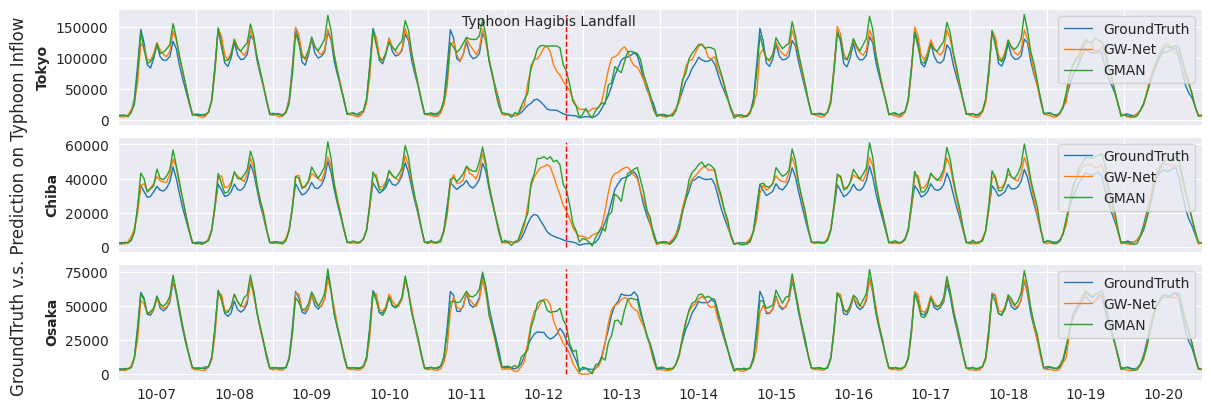

In [13]:
exp = 'typhoon-inflow'
models = ['GroundTruth', 'GW-Net', 'GMAN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 6 # future 1, 2, ..., 12 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_typhoon(exp, prefectures, fdata, times, '2019-10-07 00:00:00', '2019-10-21 00:00:00') # 14 days

npy.shape, npy.min(), npy.max() (581, 12, 47) 103.0 160730.0
npy.shape, npy.min(), npy.max() (581, 12, 47) -364.97784 176228.16
npy.shape, npy.min(), npy.max() (581, 12, 47) -1671.3596 185272.19
test_times.shape (581, 12)
(581, 3, 2) (581,) 2019-10-06 14:00:00 2019-10-30 18:00:00


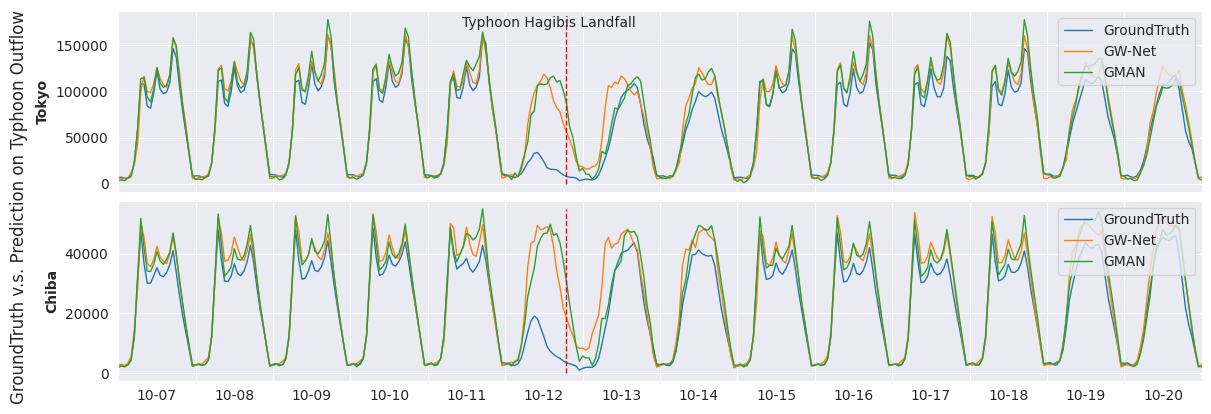

In [7]:
exp = 'typhoon-outflow'
models = ['GroundTruth', 'GW-Net', 'GMAN']
prefectures = ['Tokyo', 'Chiba']
time_step_id = 6 # future 1, 2, ..., 12 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_typhoon(exp, prefectures, fdata, times, '2019-10-07 00:00:00', '2019-10-21 00:00:00') # 14 days

In [8]:
def plot_covid(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]

    fig = plt.figure(figsize=(12, 4),  constrained_layout=True, dpi=100)
    axes = fig.subplots(len(prefectures), 1, sharex=True, gridspec_kw={'hspace': 0.01})
    sns.set_style('darkgrid')
    for area_idx in range(len(prefectures)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, :, area_idx], lw=1.0)
        ax.legend(labels=models, loc='upper right')
        ax.set_ylabel(prefectures[area_idx], fontweight='bold')
        # ax.grid(which='major', zorder=1)

    fig.supylabel('GroundTruth v.s. Prediction on {}'.format(exp_tmp))

    # Add landfall labels
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(''))
    axes[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(axes[-1].xaxis.get_minorticklabels(), rotation=0)
    axes[-1].set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}.png'.format(words[0], words[1]))

npy.shape, npy.min(), npy.max() (1753, 12, 47) 82.0 82291.0
npy.shape, npy.min(), npy.max() (1753, 12, 47) -83.741905 91028.125
npy.shape, npy.min(), npy.max() (1753, 12, 47) 74.400764 84725.32
test_times.shape (1753, 12)
(1753, 3, 3) (1753,) 2020-10-19 18:00:00 2020-12-31 18:00:00


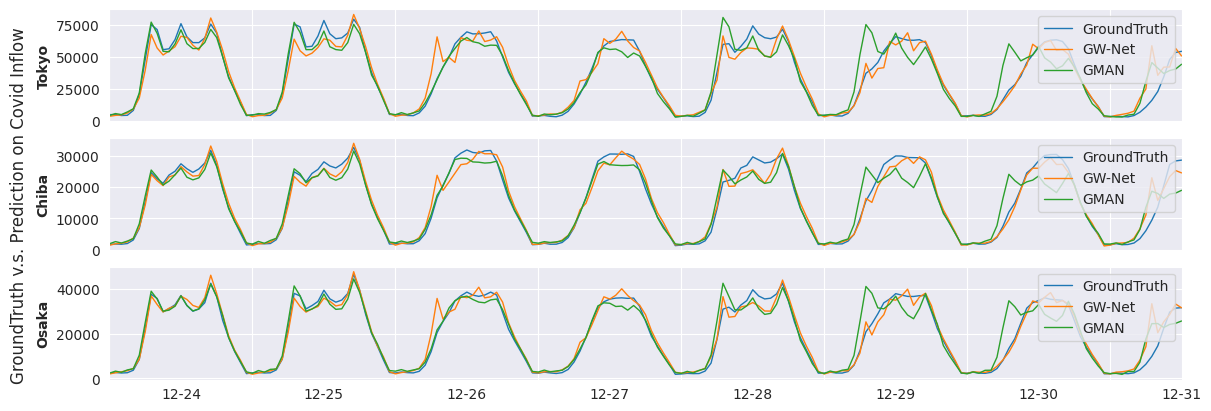

In [9]:
exp = 'covid-inflow'
models = ['GroundTruth', 'GW-Net', 'GMAN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 6 # future 1, 2, ..., 12 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_covid(exp, prefectures, fdata, times, '2020-12-24 00:00:00', '2020-12-31 12:00:00') # 14 days

npy.shape, npy.min(), npy.max() (1753, 12, 47) 82.0 89464.0
npy.shape, npy.min(), npy.max() (1753, 12, 47) 65.881386 99805.63
npy.shape, npy.min(), npy.max() (1753, 12, 47) -68.914474 103531.14
test_times.shape (1753, 12)
(1753, 3, 3) (1753,) 2020-10-19 18:00:00 2020-12-31 18:00:00


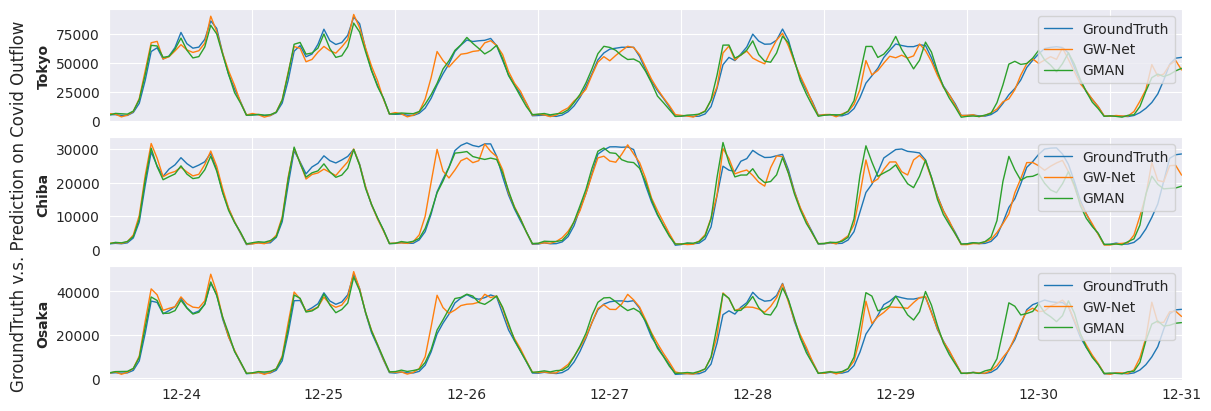

In [10]:
exp = 'covid-outflow'
models = ['GroundTruth', 'GW-Net', 'GMAN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 6 # future 1, 2, ..., 12 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_covid(exp, prefectures, fdata, times, '2020-12-24 00:00:00', '2020-12-31 12:00:00') # 14 days